In [126]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd



In [127]:

import json

with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_12_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_12_rocks_allWalks.json", "w") as f:
    json.dump(data,f)



In [128]:
framerate = data['framerate']

In [129]:
data.keys()

dict_keys(['ww', 'splitWalks_date', 'walkType', 'eyes', 'frames', 'sessionID', 'takeID', 'subID', 'shadowMarkerNames', 'processData_date', 'framerate', 'legLength', 'calibDist', 'px2mmScale', 'rVorCalibErr', 'comXYZ', 'isThisVORCalibrationData', 'rGazeGroundIntersection', 'rEyeballCenterXYZ', 'rGazeXYZ', 'headVecX_fr_xyz', 'headVecY_fr_xyz', 'headVecZ_fr_xyz', 'shadow_fr_mar_dim', 'rHeelXYZ', 'rToeXYZ', 'rFootXYZ', 'lHeelXYZ', 'lToeXYZ', 'lFootXYZ', 'hTopXYZ', 'headXYZ', 'hCenXYZ', 'steps_HS_TO_StanceLeg_XYZ', 'syncedUnixTime', 'gaze_norm_pos_x', 'gaze_norm_pos_y', 'worldFrameIndex', 'headGlobalQuat_wxyz', 'rEye_theta', 'rEye_phi', 'rEye_norm_pos_x', 'rEye_norm_pos_y', 'rEye_circle_3d_radius', 'rEye_blinks', 'sesh', 'rCorrAlignTheta', 'corrAlignTheta'])

In [130]:
frames = np.array(data['frames'])
time = np.array(data['syncedUnixTime'])
time = time -time[0]


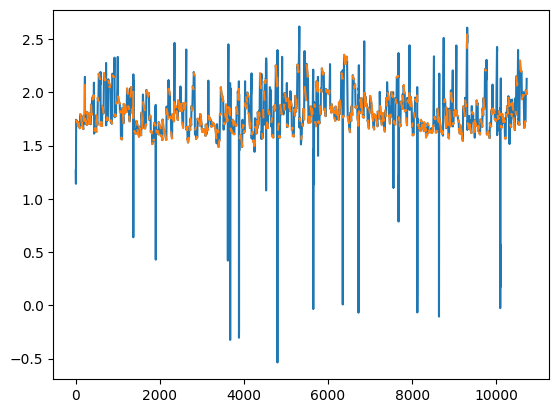

In [131]:
fixation = np.array(data['rEye_blinks'], dtype = bool)
theta = np.array(data['rEye_theta'])
phi = np.array(data['rEye_phi'])
theta_fix = np.array(data['rEye_theta'])
theta_fix[fixation] = np.nan


plt.plot(theta)
plt.plot(theta_fix)

In [132]:
fixations_df = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix})

fixations_df = fixations_df.dropna()
fixations_df['TimeDiffPrev'] = fixations_df['Time'].diff()
fixations_df['TimeDiffFol'] = fixations_df['Time'].diff(periods=-1)

In [133]:
FixStart = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009]
FixEnd = fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009]


In [134]:
steps = np.array(data['steps_HS_TO_StanceLeg_XYZ']) #frame step start, frame step end, left/right, XYZ
step_start = steps[:,0].astype(int)
step_start_time = step_start / framerate

step_end = steps[:,1].astype(int)
step_end_time = step_end / framerate

step_frames = steps[:,0:2].astype(int)
step_time = step_frames.T / framerate


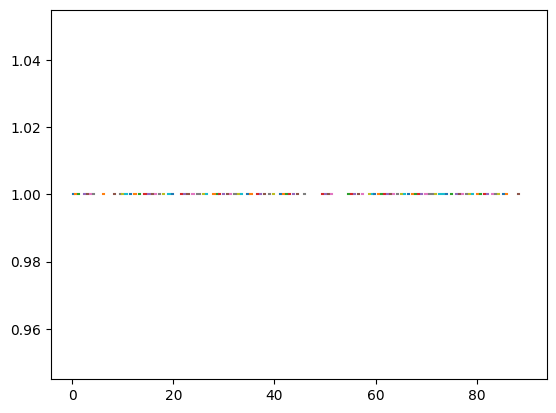

In [135]:
plt.plot(step_time , np.ones_like(step_time))

In [136]:
steps[0:8,2]

array([2., 1., 2., 1., 2., 1., 2., 1.])

In [137]:
steps_df = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]})

In [138]:
steps_df['StartTime'] = step_start_time
steps_df['EndTime'] = step_end_time


In [139]:
right_foot = steps_df.loc[(steps_df['Foot'] == 2)]
left_foot = steps_df.loc[(steps_df['Foot'] == 1)]

In [140]:
steps_df

,FrameStart,FrameEnd,Foot,X,Y,Z,StartTime,EndTime
0,19.0,30.0,2.0,328.890184,54028.169862,34.876973,0.158333,0.250000
1,74.0,86.0,1.0,702.596362,53983.003198,-138.366129,0.616667,0.716667
2,138.0,154.0,2.0,1097.389802,53953.016805,-172.828013,1.150000,1.283333
3,205.0,217.0,1.0,1541.526066,53878.893967,-320.770831,1.708333,1.808333
4,271.0,296.0,2.0,1949.974564,53858.080389,-260.215106,2.258333,2.466667
...,...,...,...,...,...,...,...,...
133,10456.0,10467.0,1.0,52180.066992,60747.337912,-385.354139,87.133333,87.225000
134,10515.0,10521.0,2.0,52700.631330,60686.046680,-261.912358,87.625000,87.675000
135,10576.0,10595.0,1.0,53473.226188,60777.067971,-125.332345,88.133333,88.291667
136,10647.0,10662.0,2.0,53905.026003,60826.335645,8.251712,88.725000,88.850000


(0.0, 1.6)

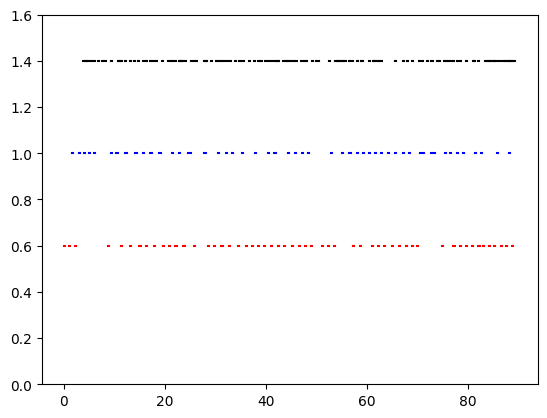

In [141]:
plt.plot((FixStart['Time'][3:], FixEnd['Time'][3:]), np.full_like((FixStart['Time'][3:],FixEnd['Time'][3:]),
                                                                           1.4, dtype=float), color = 'black')  

plt.plot((left_foot['StartTime'],left_foot['EndTime']), np.ones_like((left_foot['StartTime'],left_foot['EndTime'])), color = 'blue')
plt.plot((right_foot['StartTime'],right_foot['EndTime']), np.full_like((right_foot['StartTime'],right_foot['EndTime']),
                                                                            0.6, dtype=float), color = 'red')                                                       
plt.ylim(0,1.6)   